In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [6]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

In [7]:
%autoreload

cohort = mre_pinn.data.PatientCohort(xarray_dir='../data/NAFLD', patient_ids='0006')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/mask.nc
100%|██████████| 1/1 [00:00<00:00, 26.19it/s]


In [146]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [147]:
%autoreload

pino = mre_pinn.model.pino.SpectralAttention(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_modes=128
)
pino

SpectralAttention(n_spatial_dims=3, n_channels_in=4, n_channels_out=1, n_modes=128)

In [150]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.standardized_msae_loss_fn(u_true.values)
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000168 s



Training model...

0         [1.00e-08, 1.00e+00]    [1.00e-08, 1.00e+00]    []  


<IPython.core.display.Javascript object>


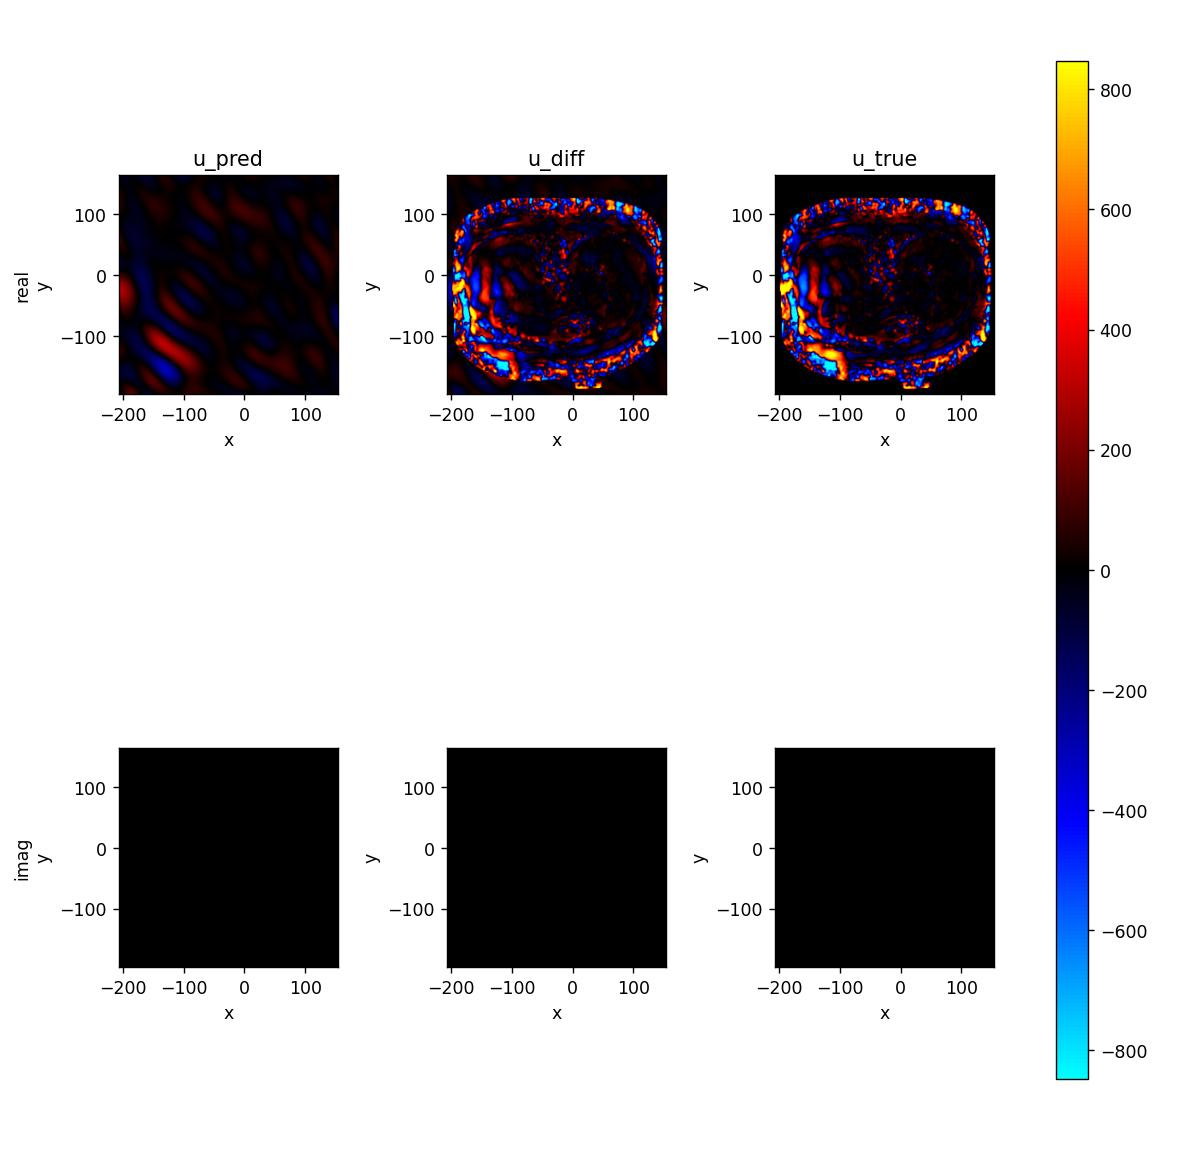

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 21.01%
10        [1.08e-08, 1.08e+00]    [1.08e-08, 1.08e+00]    []  
Time spent testing: 17.13%
20        [1.00e-08, 1.00e+00]    [1.00e-08, 1.00e+00]    []  
Time spent testing: 15.71%
30        [1.00e-08, 1.00e+00]    [1.00e-08, 1.00e+00]    []  
Time spent testing: 15.05%
40        [9.94e-09, 9.94e-01]    [9.94e-09, 9.94e-01]    []  
Time spent testing: 14.63%
50        [9.89e-09, 9.89e-01]    [9.89e-09, 9.89e-01]    []  
Time spent testing: 14.36%
60        [9.85e-09, 9.85e-01]    [9.85e-09, 9.85e-01]    []  
Time spent testing: 14.17%
70        [9.83e-09, 9.83e-01]    [9.83e-09, 9.83e-01]    []  
Time spent testing: 14.01%
80        [9.81e-09, 9.81e-01]    [9.81e-09, 9.81e-01]    []  
Time spent testing: 13.90%
90        [9.80e-09, 9.80e-01]    [9.80e-09, 9.80e-01]    []  
Time spent testing: 13.82%
100       [9.79e-09, 9.79e-01]    [9.79e-09, 9.79e-01]    []  
Time spent testing: 13.76%
110       [9.77e-09, 9.77e-01]    [9.77e-09, 9.77e-01]    []  
Time spent

KeyboardInterrupt: 

In [151]:
model.train(10000, display_every=10, callbacks=[test_eval])